### Copyright (C) 2022 Sobhan Moradian Daghigh
#### - 3/16/2022
#### - ANN - EX02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns

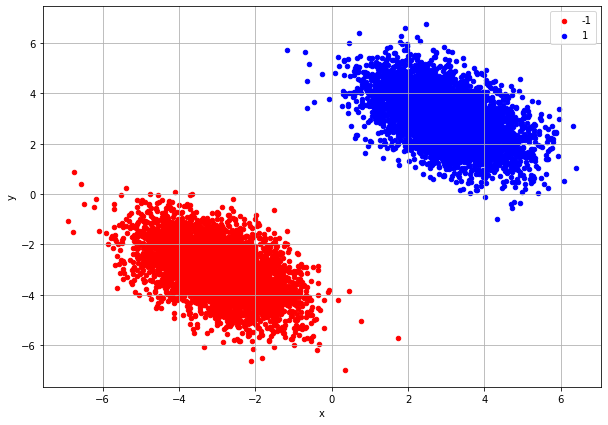

In [2]:
mean1, mean2, cov = [-3, -3], [3, 3], [[1, -0.5], [-0.5, 1]]

X1 = np.random.multivariate_normal(mean1, cov, 5000)
X2 = np.random.multivariate_normal(mean2, cov, 5000)

df1 = pd.DataFrame(dict(x=X1[:,0], y=X1[:,1], label=[-1] * X1.shape[0]))
df2 = pd.DataFrame(dict(x=X2[:,0], y=X2[:,1], label=[1] * X2.shape[0]))

frames = [df1, df2]
dataset = pd.concat(frames)

colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots(figsize=(10, 7))
for grp, pdf in dataset.groupby(by='label'):
    pdf.plot(ax=ax, kind='scatter', x='x', y='y', label=grp, color=colors[grp])

plt.grid(True)
plt.show()

In [3]:
dataset.head()

x         y  label
0 -1.326180 -4.160055     -1
1 -3.613954 -3.032478     -1
2 -0.906984 -5.314861     -1
3 -2.870097 -2.986286     -1
4 -1.758746 -3.727678     -1

### Splitting the data into 70% of train, 20% of test and 10% of validation 

In [4]:
x_temp, x_test, y_temp, y_test = train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.125, random_state=42)

In [5]:
x_train.shape, x_test.shape, x_val.shape

((7000, 2), (2000, 2), (1000, 2))

In [6]:
def error_plotter(err1, err2):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(range(1, len(err1) + 1), err1, 'g-', label='train')
    ax.plot(range(1, len(err2) + 1), err2, 'r-', label='validation')
    ax.legend()
    plt.show()

In [7]:
def decision_boundary_plotter(x_train, y_train, clf):

    # step size in the mesh
    h = 0.02 
    
    # create a mesh to plot in
    x_min, x_max = x_train.iloc[:, 0].min() - 1, x_train.iloc[:, 0].max() + 1
    y_min, y_max = x_train.iloc[:, 1].min() - 1, x_train.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    colors = {-1:'red', 1:'blue'}
    fig, ax = plt.subplots(figsize=(10, 7))

    Z = clf.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()]))

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    ax.axis('off')

    # Plot also the training points
    ax.scatter(x_train.iloc[:, 0], x_train.iloc[:, 1], c=y_train, cmap=plt.cm.Paired)

    for grp, pdf in dataset.groupby(by='label'):
        pdf.plot(ax=ax, kind='scatter', x='x', y='y', label=grp, color=colors[grp])
        
    ax.set_title('Perceptron')
    plt.grid(True)
    plt.show()

In [8]:
class Perceptron:    
    def fit(self, x_train, x_val, y_train, y_val, lr=0.01, n_iter=100, act_func='linear', not_linear=False):
        
        self.not_linear = not_linear
        
        if self.not_linear:
            x_train_augmented = x_train
            x_train_augmented['xx'] = np.power(x_train.iloc[:, 0], 2)
            x_train_augmented['yy'] = np.power(x_train.iloc[:, 1], 2)
            x_train_augmented['xy'] = np.multiply(x_train.iloc[:, 0], x_train.iloc[:, 1])
            
        n_samples = x_train.shape[0]
        n_features = x_train.shape[1]
        
        self.learning_rate = lr
        self.act_func = act_func
        self.thresh = {'linear': 0, 'relu': 0.5, 'sigmoid': 0.5, 'tanh': 0}
        
        # Add 1 for the bias term
        self.weights = np.zeros((n_features + 1,))
        
        # Add column of 1s
        if self.not_linear:
            x_train_augmented = np.concatenate([x_train_augmented, np.ones((n_samples, 1))], axis=1)
            
        else:
            x_train_augmented = np.concatenate([x_train, np.ones((n_samples, 1))], axis=1)
        
        train_errors = []
        val_errors = []
        for i in range(n_iter):
            err = 0
            for j in range(n_samples):
                out = np.dot(self.weights, x_train_augmented[j, :])
                out = self.activation_func(out)
                pred = np.where(out >= self.thresh[self.act_func], 1, -1)
                error = np.subtract(y_train[j], pred)
                if error != 0:
                    err += 1
                
                self.weights += np.multiply(self.learning_rate, np.multiply(error, x_train_augmented[j, :]))
            
            train_errors.append(self.cal_error(x_train, y_train))
            val_errors.append(self.cal_error(x_val, y_val))

            if err == 0:
                break
        
        return train_errors, val_errors, i + 1
    
    def predict(self, X):
        if not hasattr(self, 'weights'):
            print('The model is not trained yet!')
            return
        
        if self.not_linear:
            X['xx'] = np.power(X.iloc[:, 0], 2)
            X['yy'] = np.power(X.iloc[:, 1], 2)
            X['xy'] = np.multiply(X.iloc[:, 0], X.iloc[:, 1])
        
        n_samples = X.shape[0]
        # Add column of 1s
        X = np.concatenate([X, np.ones((n_samples, 1))], axis=1)
        y = np.matmul(X, self.weights)
        y = self.activation_func(y)       
        return y
    
    def score(self, X, y):
        pred_y = self.predict(X)
        return np.mean(y == pred_y)
    
    def cal_error(self, X, y):
        pred_y = self.predict(X)
        return np.mean(y != pred_y)
    
    def activation_func(self, X):
        if self.act_func == 'linear':
            return np.vectorize(lambda val: 1 if val > self.thresh[self.act_func] else -1)(X)
        elif self.act_func == 'relu':
            return np.vectorize(lambda val: 1 if val > self.thresh[self.act_func] else -1)(np.maximum(X, 0))
        elif self.act_func == 'sigmoid':
            return np.vectorize(lambda val: 1 if val > self.thresh[self.act_func] else -1)(np.divide(1, np.add(1, np.exp(-X))))
        elif self.act_func == 'tanh':
            return np.vectorize(lambda val: 1 if val > self.thresh[self.act_func] else -1)(np.tanh(X))

In [9]:
class Adaline:    
    def fit(self, x_train, x_val, y_train, y_val, lr=0.01, n_iter=100, act_func='linear', not_linear=False):
        
        self.not_linear = not_linear
        
        if self.not_linear:
            x_train_augmented = x_train
            x_train_augmented['xx'] = np.power(x_train.iloc[:, 0], 2)
            x_train_augmented['yy'] = np.power(x_train.iloc[:, 1], 2)
            x_train_augmented['xy'] = np.multiply(x_train.iloc[:, 0], x_train.iloc[:, 1])
            
        n_samples = x_train.shape[0]
        n_features = x_train.shape[1]
        
        self.learning_rate = lr
        self.act_func = act_func
        self.thresh = {'linear': 0, 'relu': 0.5, 'sigmoid': 0.5, 'tanh': 0}
        
        # Add 1 for the bias term
        self.weights = np.zeros((n_features + 1,))
        
        # Add column of 1s
        if self.not_linear:
            x_train_augmented = np.concatenate([x_train_augmented, np.ones((n_samples, 1))], axis=1)
            
        else:
            x_train_augmented = np.concatenate([x_train, np.ones((n_samples, 1))], axis=1)
            
        train_errors = []
        val_errors = []
        for i in range(n_iter):
            err = 0
            for j in range(n_samples):
                out = np.dot(x_train_augmented[j, :], self.weights)
                error = np.subtract(y_train[j], out)
                if error != 0:
                    err += 1
                self.weights += np.multiply(self.learning_rate, np.multiply(np.multiply(2, error), x_train_augmented[j, :]))
                
            train_errors.append(self.cal_error(x_train, y_train))
            val_errors.append(self.cal_error(x_val, y_val))
            
            if err == 0:
                break
                
        return train_errors, val_errors, i + 1
        
    
    def predict(self, X):
        if not hasattr(self, 'weights'):
            print('The model is not trained yet!')
            return
        
        if self.not_linear:
            X['xx'] = np.power(X.iloc[:, 0], 2)
            X['yy'] = np.power(X.iloc[:, 1], 2)
            X['xy'] = np.multiply(X.iloc[:, 0], X.iloc[:, 1])
            
        n_samples = X.shape[0]
        # Add column of 1s
        X = np.concatenate([X, np.ones((n_samples, 1))], axis=1)
        y = np.matmul(X, self.weights)
        y = self.activation_func(y)       
        return y
    
    def score(self, X, y):
        pred_y = self.predict(X)
        return np.mean(y == pred_y)

    def cal_error(self, X, y):
        pred_y = self.predict(X)
        return np.mean(y != pred_y)
    
    def activation_func(self, X):
        if self.act_func == 'linear':
            return np.vectorize(lambda val: 1 if val > self.thresh[self.act_func] else -1)(X)
        elif self.act_func == 'relu':
            return np.vectorize(lambda val: 1 if val > self.thresh[self.act_func] else -1)(np.maximum(X, 0))
        elif self.act_func == 'sigmoid':
            return np.vectorize(lambda val: 1 if val > self.thresh[self.act_func] else -1)(np.divide(1, np.add(1, np.exp(-X))))
        elif self.act_func == 'tanh':
            return np.vectorize(lambda val: 1 if val > self.thresh[self.act_func] else -1)(np.tanh(X))

Converge in 2 iteration with learning-rate: 0.0001
Accuracy: 1.0


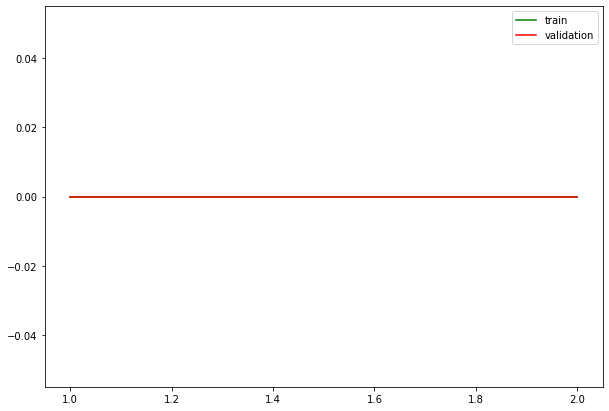

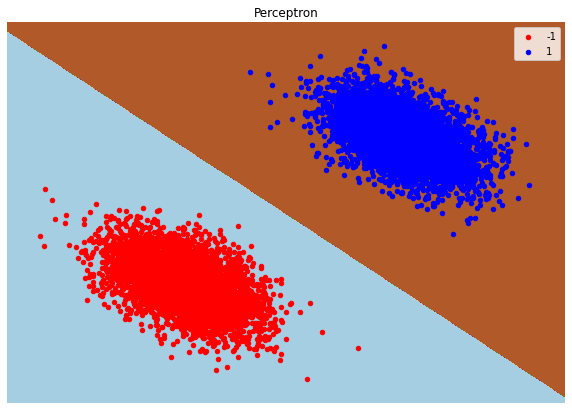

Converge in 2 iteration with learning-rate: 0.001
Accuracy: 1.0


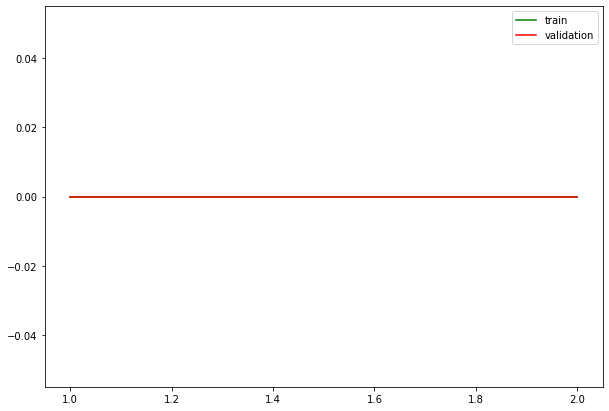

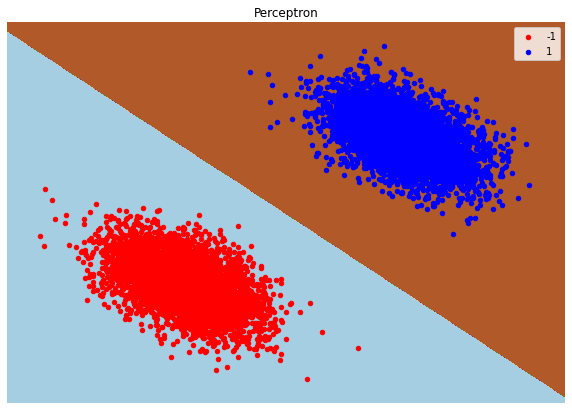

Converge in 2 iteration with learning-rate: 0.01
Accuracy: 1.0


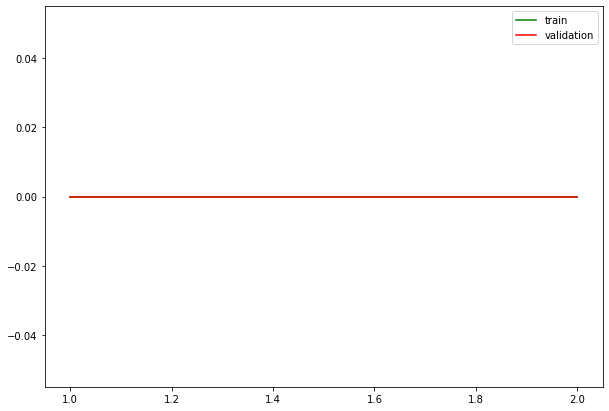

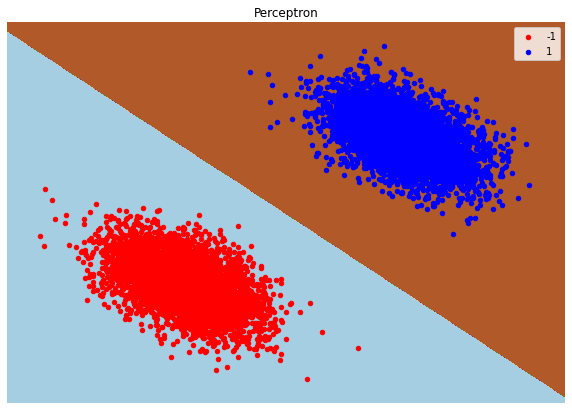

Converge in 2 iteration with learning-rate: 0.1
Accuracy: 1.0


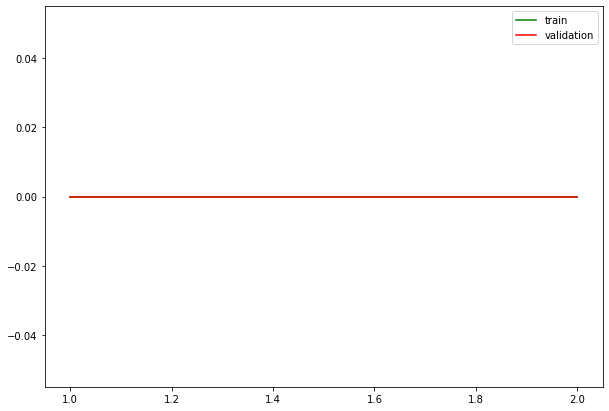

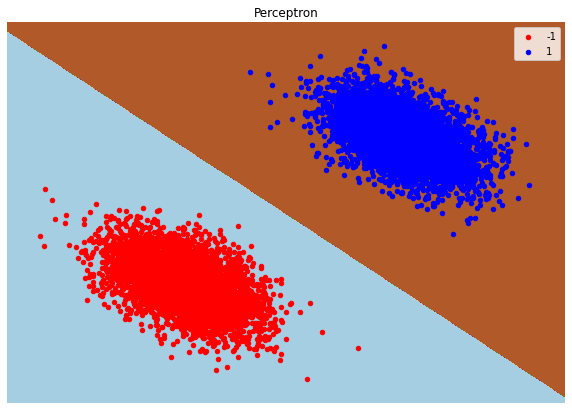

Converge in 2 iteration with learning-rate: 0.9
Accuracy: 1.0


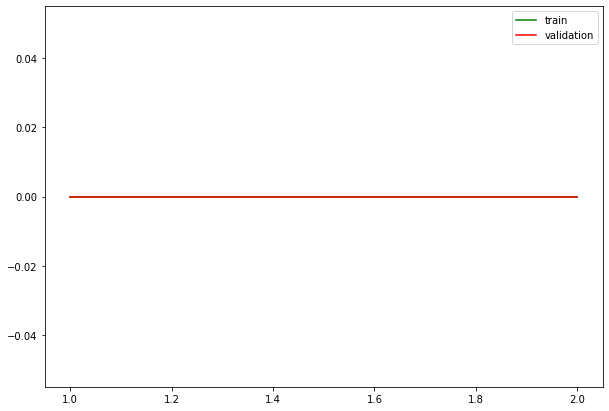

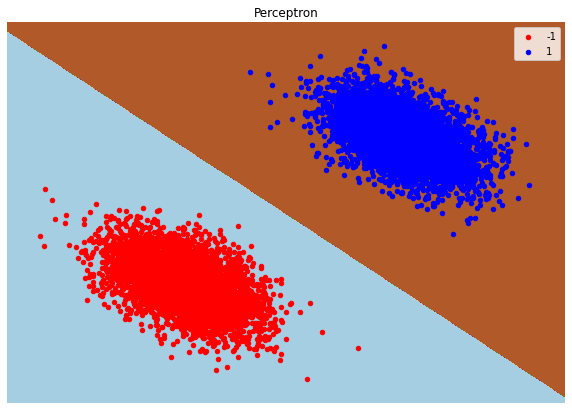

In [10]:
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1, 9e-1]
for lr in learning_rates:
    perceptron = Perceptron()
    train_errors, val_errors, iteration = perceptron.fit(x_train, x_val, y_train.tolist(), y_val.tolist(), lr=lr)
    acc = perceptron.score(x_test, y_test)
    print('Converge in {} iteration with learning-rate: {}'.format(iteration, lr))
    print('Accuracy: {}'.format(acc))
    error_plotter(train_errors, val_errors)
    decision_boundary_plotter(x_train, y_train, perceptron)    

Converge in 2 iteration with activation function: linear
Accuracy: 1.0


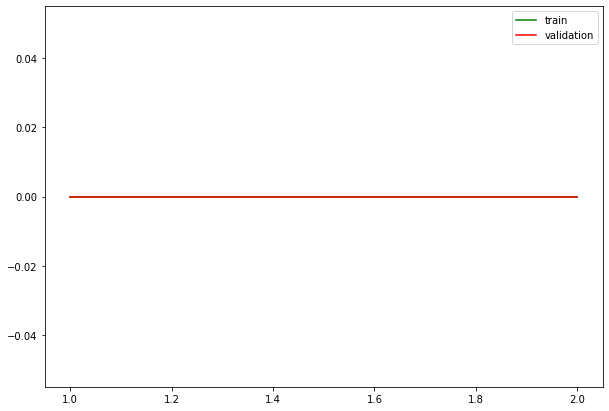

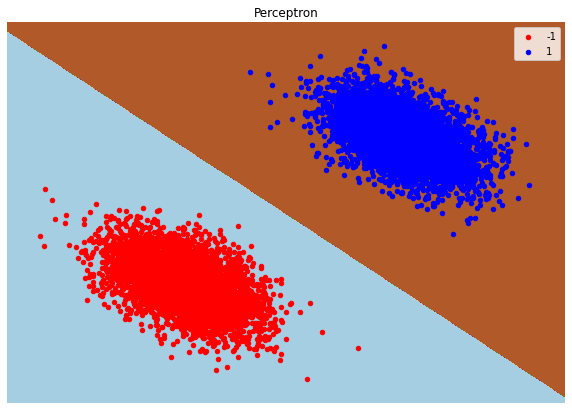

Converge in 2 iteration with activation function: relu
Accuracy: 1.0


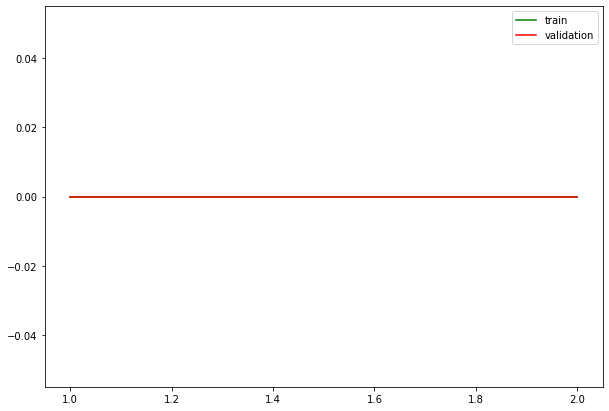

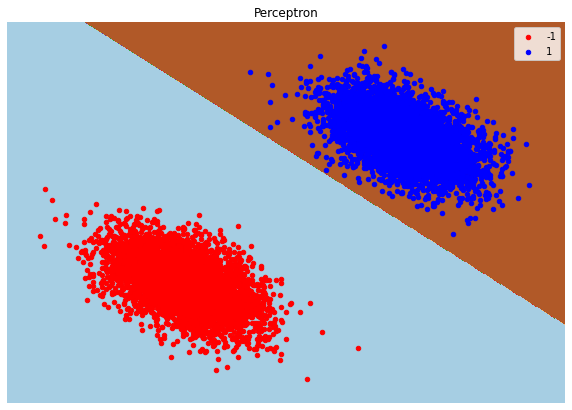

Converge in 2 iteration with activation function: sigmoid
Accuracy: 1.0


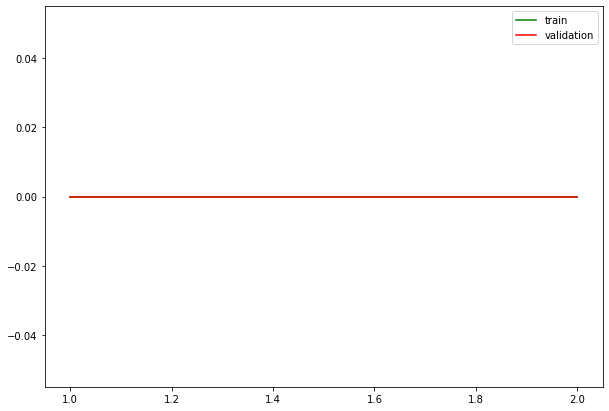

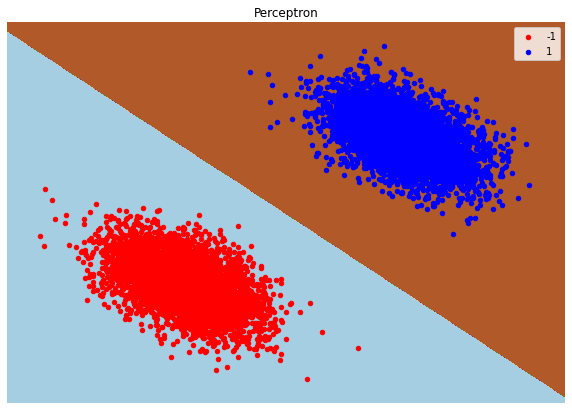

Converge in 2 iteration with activation function: tanh
Accuracy: 1.0


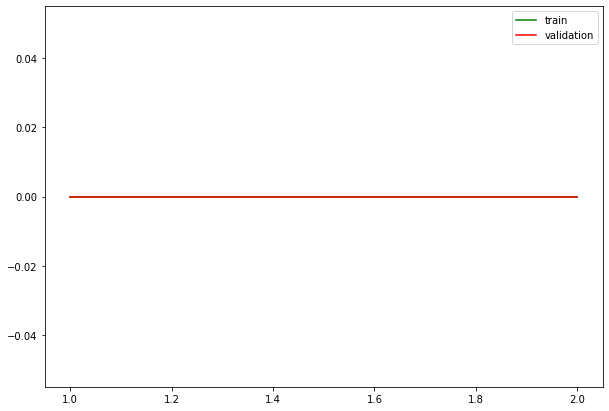

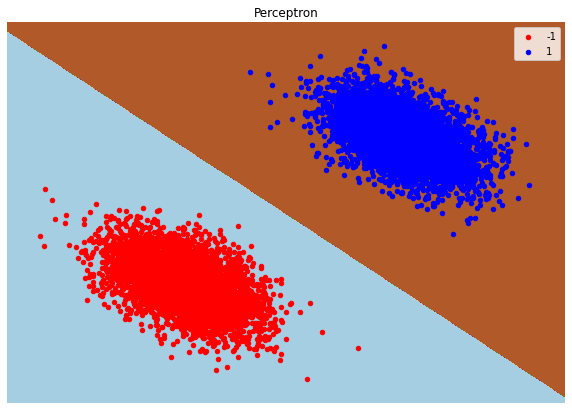

In [11]:
act_funcs = ['linear', 'relu', 'sigmoid', 'tanh']
for func in act_funcs:
    perceptron = Perceptron()
    train_errors, val_errors, iteration = perceptron.fit(x_train, x_val, y_train.tolist(), y_val.tolist(), act_func=func)
    acc = perceptron.score(x_test, y_test)
    print('Converge in {} iteration with activation function: {}'.format(iteration, func))
    print('Accuracy: {}'.format(acc))
    error_plotter(train_errors, val_errors)
    decision_boundary_plotter(x_train, y_train, perceptron)    

Converge in 100 iteration with learning-rate: 1e-06
Accuracy: 1.0


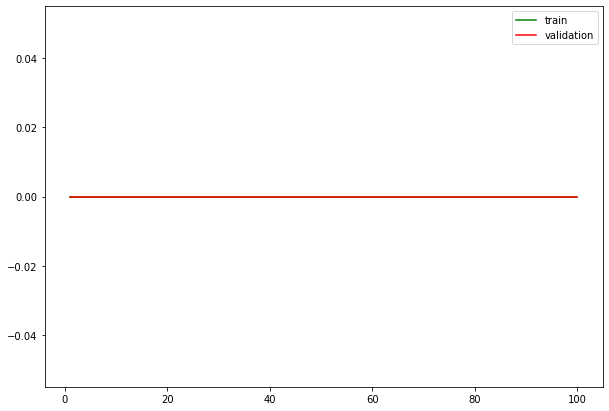

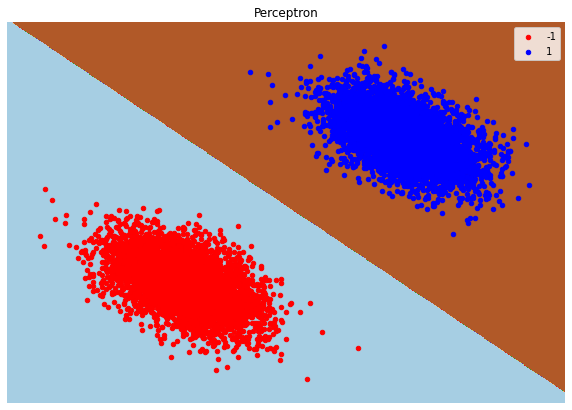

Converge in 100 iteration with learning-rate: 1e-05
Accuracy: 1.0


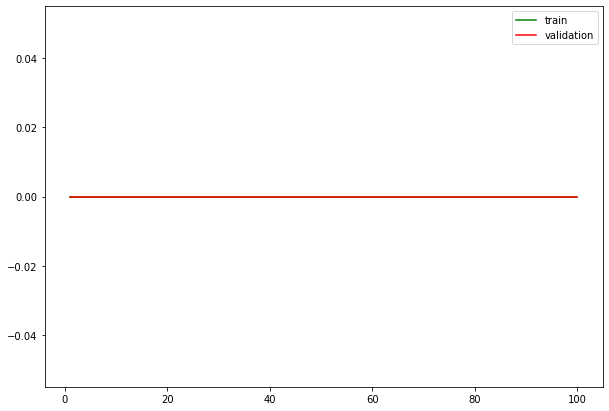

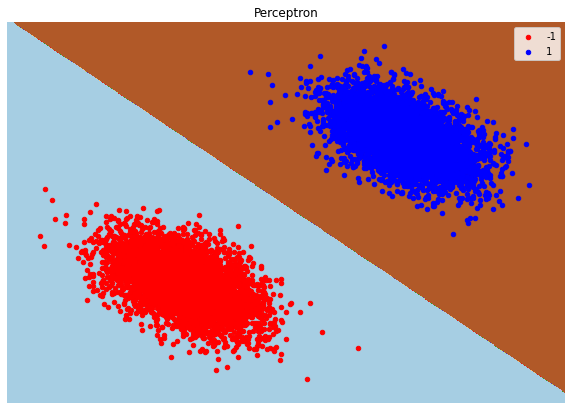

Converge in 100 iteration with learning-rate: 0.0001
Accuracy: 1.0


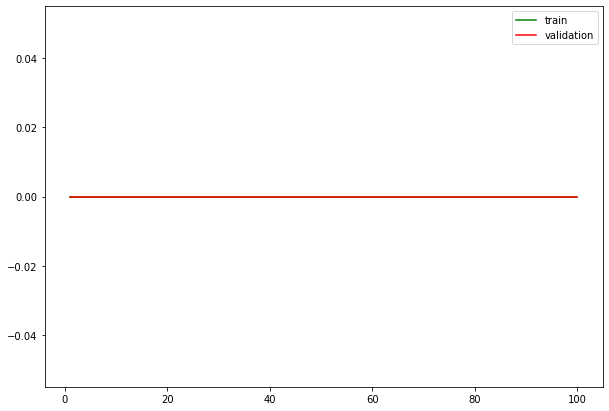

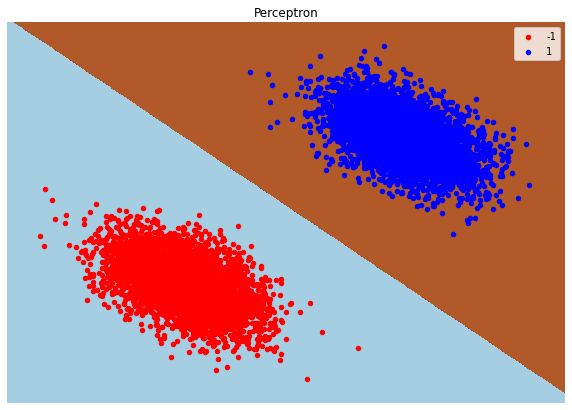

Converge in 100 iteration with learning-rate: 0.001
Accuracy: 1.0


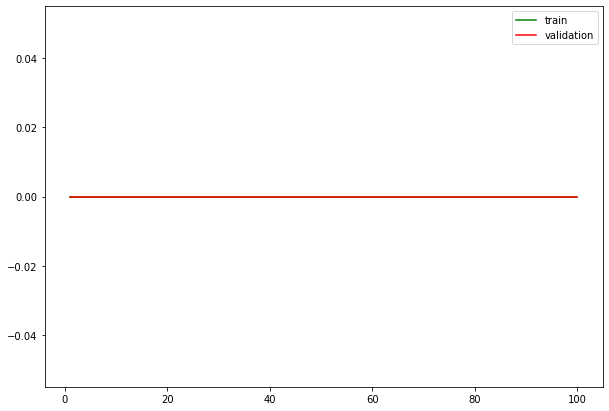

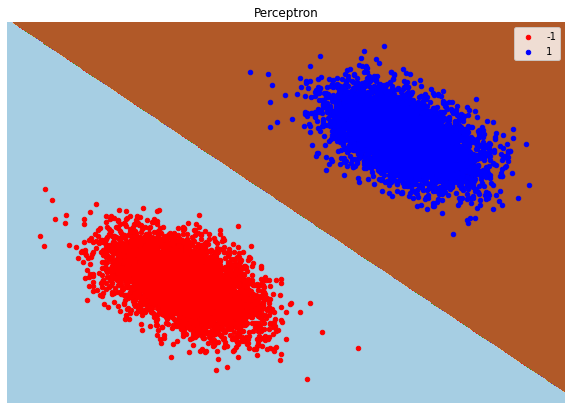

Converge in 100 iteration with learning-rate: 0.01
Accuracy: 1.0


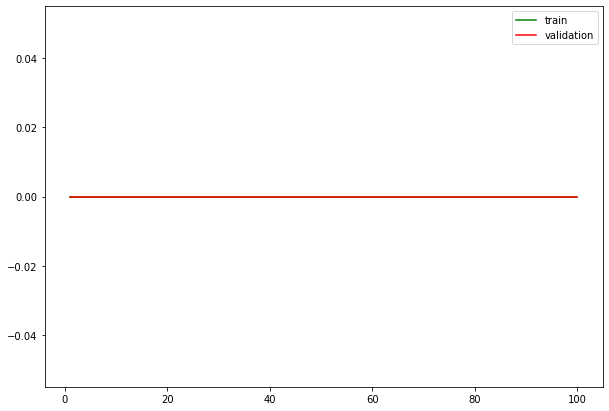

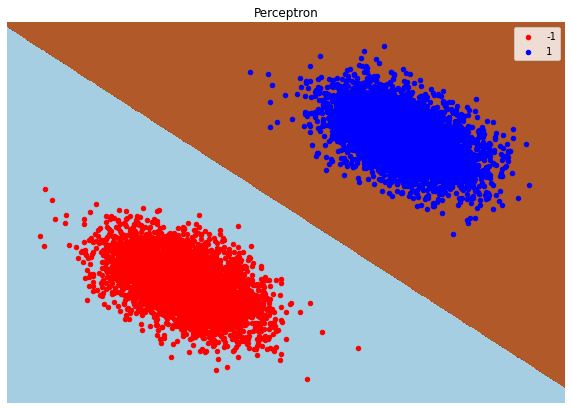

In [12]:
learning_rates = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
for lr in learning_rates:
    adaline = Adaline()
    train_errors, val_errors, iteration = adaline.fit(x_train, x_val, y_train.tolist(), y_val.tolist(), lr=lr)
    acc = adaline.score(x_test, y_test)
    print('Converge in {} iteration with learning-rate: {}'.format(iteration, lr))
    print('Accuracy: {}'.format(acc))
    error_plotter(train_errors, val_errors)
    decision_boundary_plotter(x_train, y_train, adaline)

Converge in 100 iteration with activation function: linear
Accuracy: 1.0


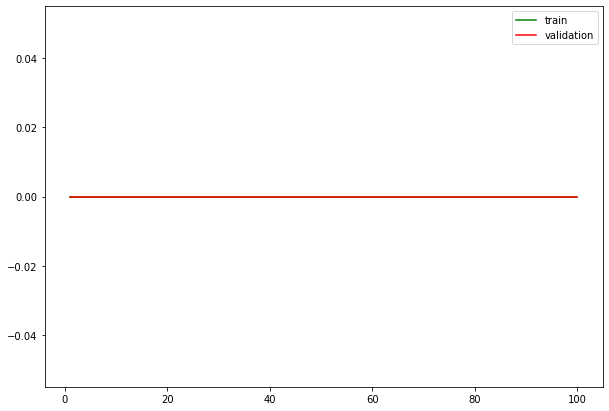

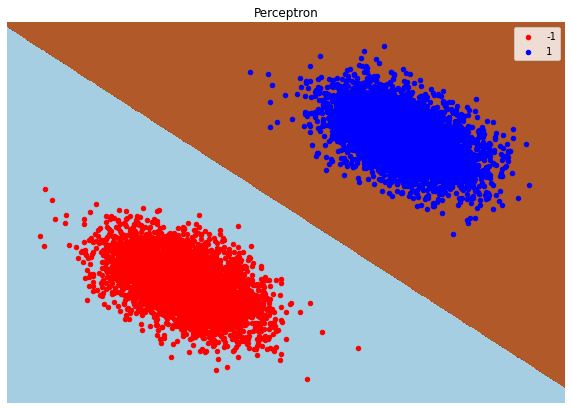

Converge in 100 iteration with activation function: relu
Accuracy: 1.0


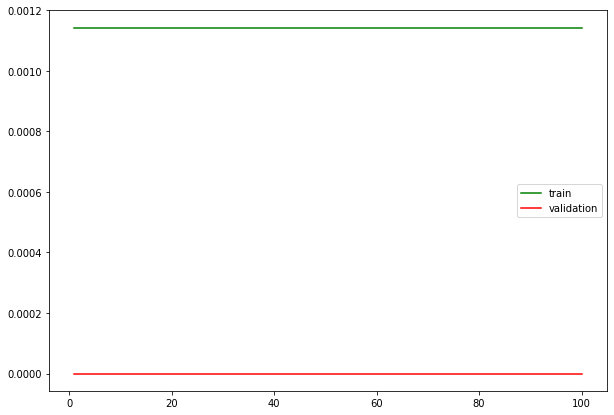

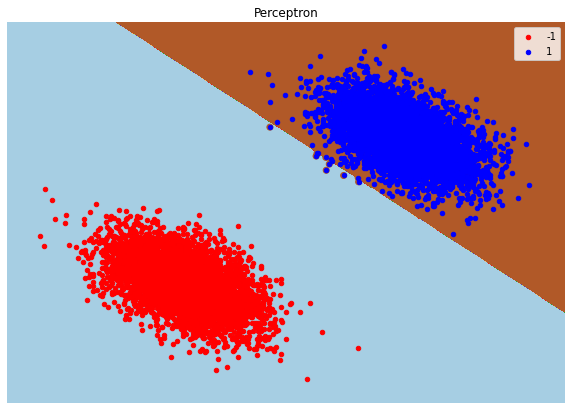

Converge in 100 iteration with activation function: sigmoid
Accuracy: 1.0


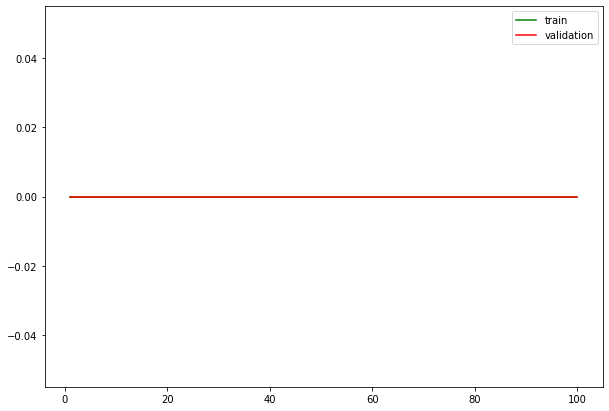

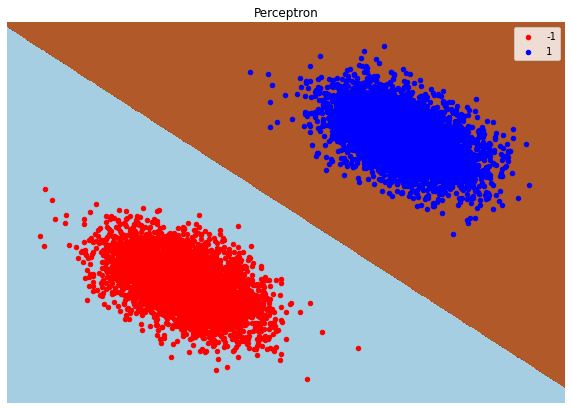

Converge in 100 iteration with activation function: tanh
Accuracy: 1.0


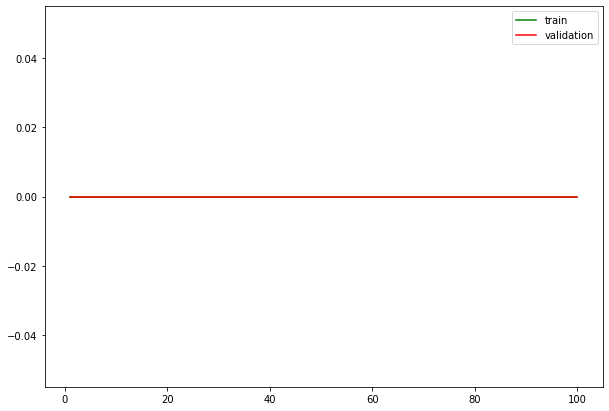

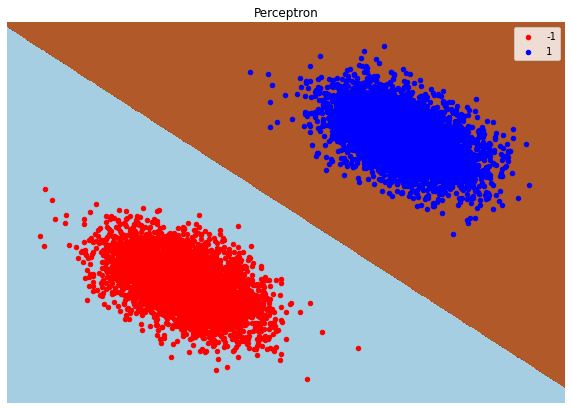

In [13]:
act_funcs = ['linear', 'relu', 'sigmoid', 'tanh']
for func in act_funcs:
    adaline = Adaline()
    train_errors, val_errors, iteration = adaline.fit(x_train, x_val, y_train.tolist(), y_val.tolist(), act_func=func)
    acc = adaline.score(x_test, y_test)
    print('Converge in {} iteration with activation function: {}'.format(iteration, func))
    print('Accuracy: {}'.format(acc))
    error_plotter(train_errors, val_errors)
    decision_boundary_plotter(x_train, y_train, adaline)

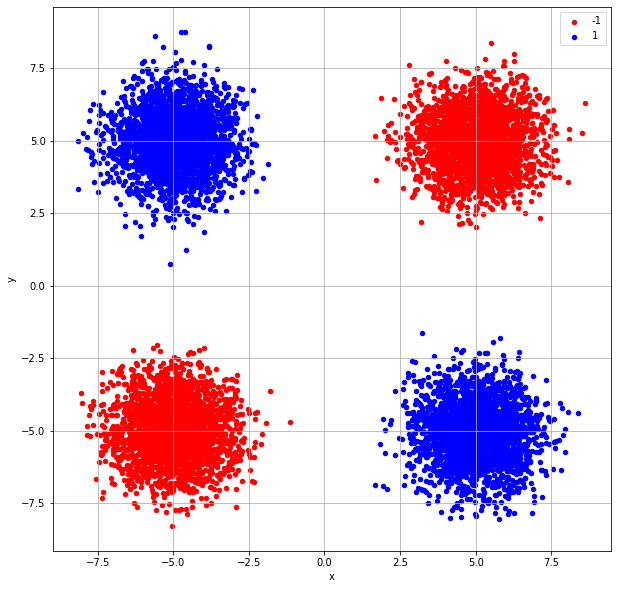

In [14]:
mean11, mean12, mean21, mean22, cov = [-5, -5], [-5, 5], [5, -5], [5, 5], [[1, 0], [0, 1]]

X11 = np.random.multivariate_normal(mean11, cov, 2500)
X22 = np.random.multivariate_normal(mean22, cov, 2500)
X12 = np.random.multivariate_normal(mean12, cov, 2500)
X21 = np.random.multivariate_normal(mean21, cov, 2500)

df11 = pd.DataFrame(dict(x=X11[:,0], y=X11[:,1], label=[-1] * X11.shape[0]))
df22 = pd.DataFrame(dict(x=X22[:,0], y=X22[:,1], label=[-1] * X22.shape[0]))
df12 = pd.DataFrame(dict(x=X12[:,0], y=X12[:,1], label=[1] * X12.shape[0]))
df21 = pd.DataFrame(dict(x=X21[:,0], y=X21[:,1], label=[1] * X21.shape[0]))

frames = [df11, df12, df21, df22]
dataset = pd.concat(frames)

colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots(figsize=(10, 10))
for grp, pdf in dataset.groupby(by='label'):
    pdf.plot(ax=ax, kind='scatter', x='x', y='y', label=grp, color=colors[grp])

plt.grid(True)
plt.show()

### Splitting the data into 70% of train, 20% of test and 10% of validation 

In [15]:
x_temp, x_test, y_temp, y_test = train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1], test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.125, random_state=42)

In [16]:
x_train.shape, x_test.shape, x_val.shape

((7000, 2), (2000, 2), (1000, 2))

Converge in 100 iteration with learning-rate: 0.0001
Accuracy: 0.494


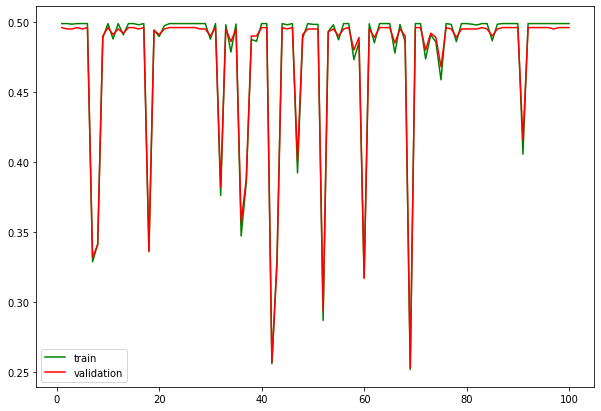

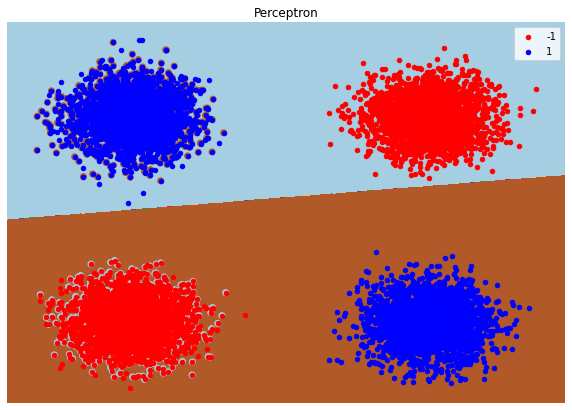

Converge in 100 iteration with learning-rate: 0.001
Accuracy: 0.494


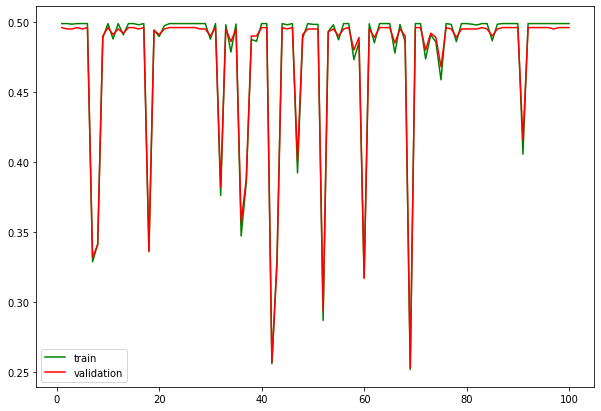

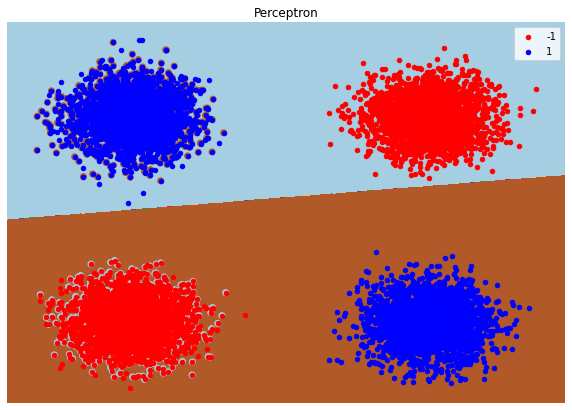

Converge in 100 iteration with learning-rate: 0.01
Accuracy: 0.494


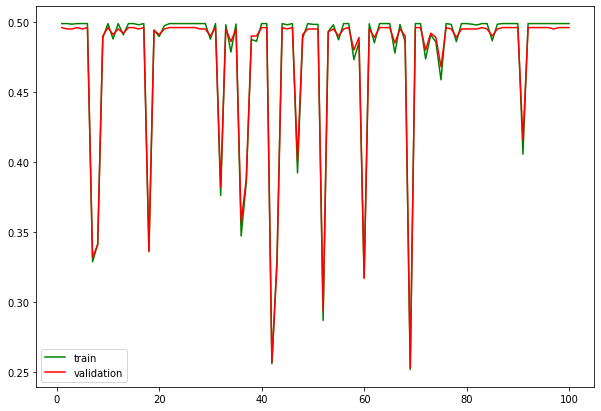

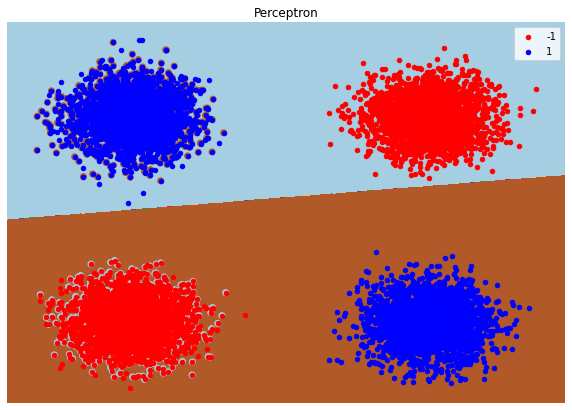

Converge in 100 iteration with learning-rate: 0.1
Accuracy: 0.494


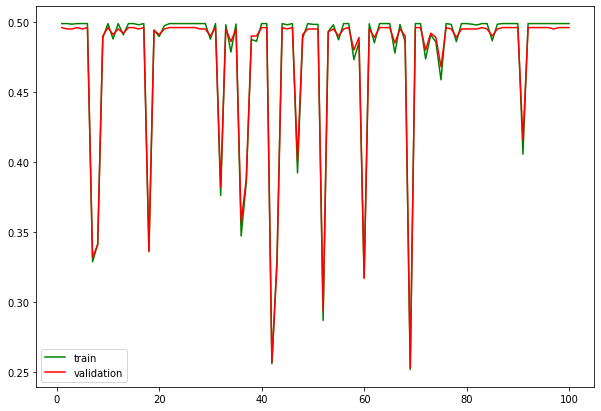

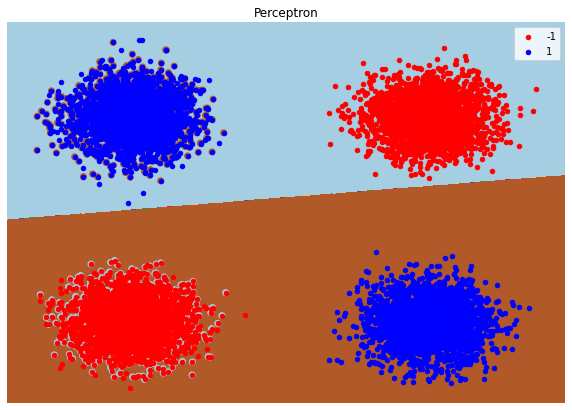

Converge in 100 iteration with learning-rate: 0.9
Accuracy: 0.494


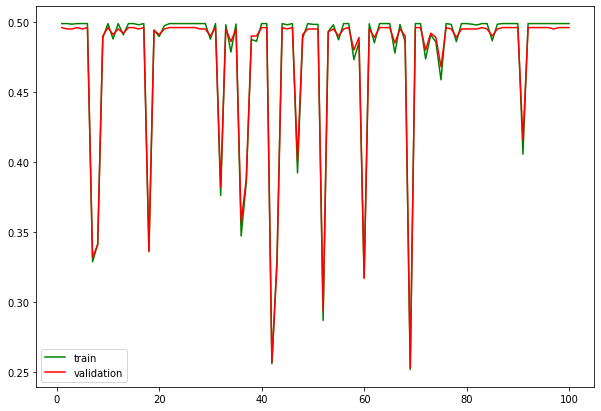

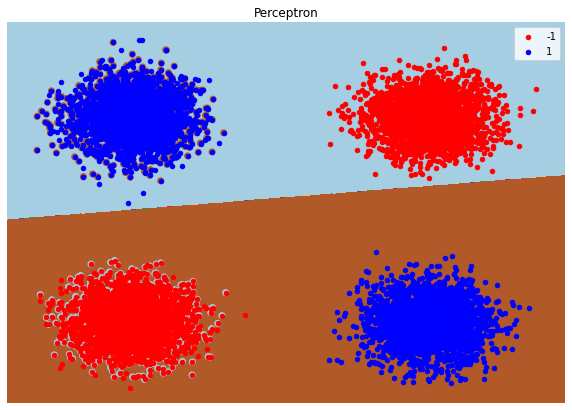

In [17]:
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1, 9e-1]
for lr in learning_rates:
    perceptron = Perceptron()
    train_errors, val_errors, iteration = perceptron.fit(x_train, x_val, y_train.tolist(), y_val.tolist(), lr=lr)
    acc = perceptron.score(x_test, y_test)
    print('Converge in {} iteration with learning-rate: {}'.format(iteration, lr))
    print('Accuracy: {}'.format(acc))
    error_plotter(train_errors, val_errors)
    decision_boundary_plotter(x_train, y_train, perceptron)

Converge in 100 iteration with activation function: linear
Accuracy: 0.494


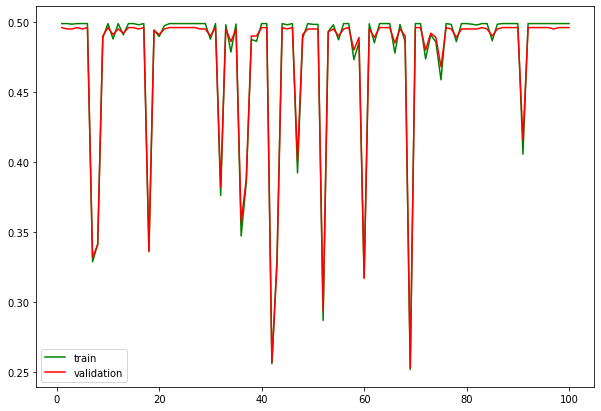

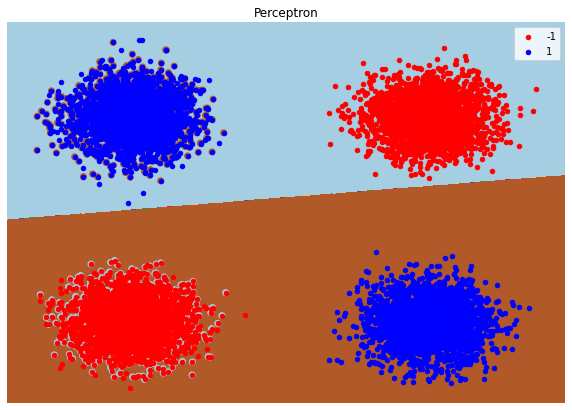

Converge in 100 iteration with activation function: relu
Accuracy: 0.5135


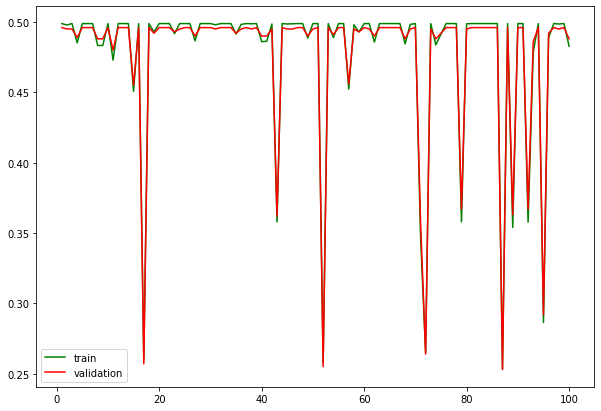

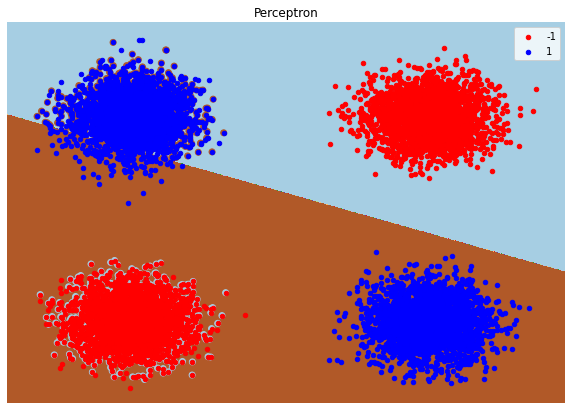

Converge in 100 iteration with activation function: sigmoid
Accuracy: 0.494


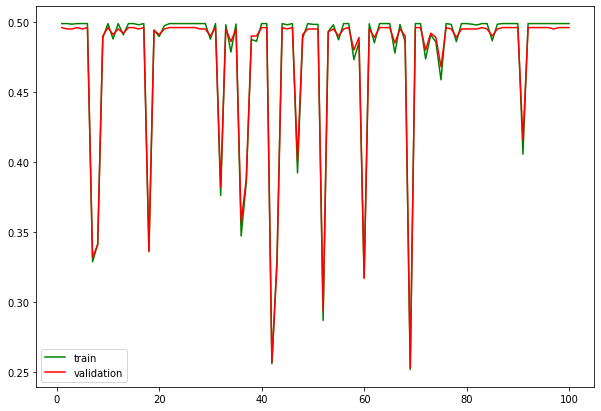

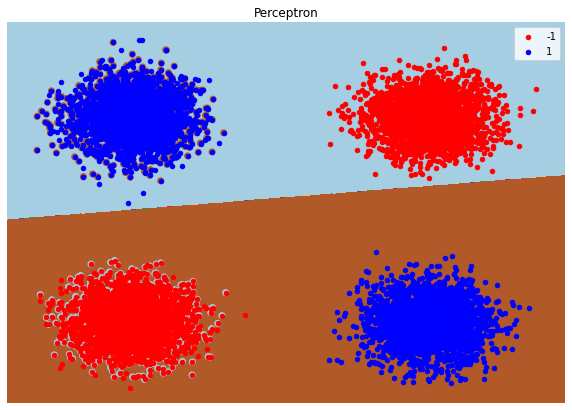

Converge in 100 iteration with activation function: tanh
Accuracy: 0.494


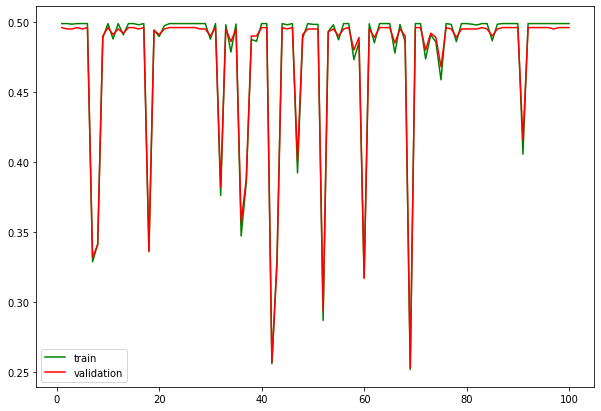

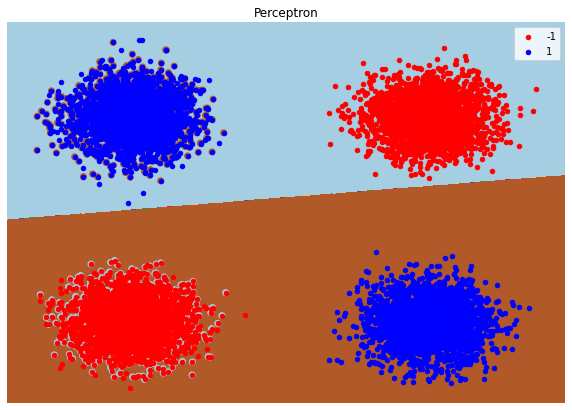

In [18]:
act_funcs = ['linear', 'relu', 'sigmoid', 'tanh']
for func in act_funcs:
    perceptron = Perceptron()
    train_errors, val_errors, iteration = perceptron.fit(x_train, x_val, y_train.tolist(), y_val.tolist(), act_func=func)
    acc = perceptron.score(x_test, y_test)
    print('Converge in {} iteration with activation function: {}'.format(iteration, func))
    print('Accuracy: {}'.format(acc))
    error_plotter(train_errors, val_errors)
    decision_boundary_plotter(x_train, y_train, perceptron)

Converge in 100 iteration with learning-rate: 1e-06
Accuracy: 0.4565


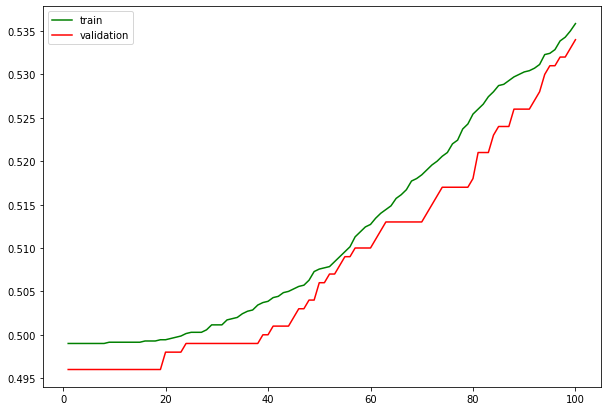

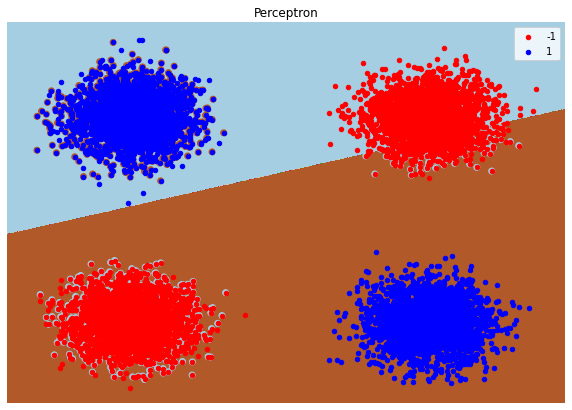

Converge in 100 iteration with learning-rate: 1e-05
Accuracy: 0.494


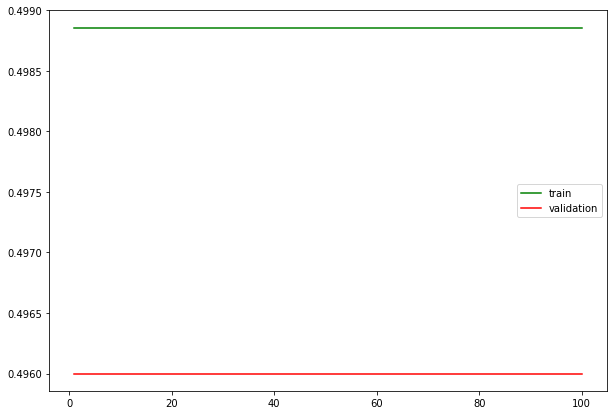

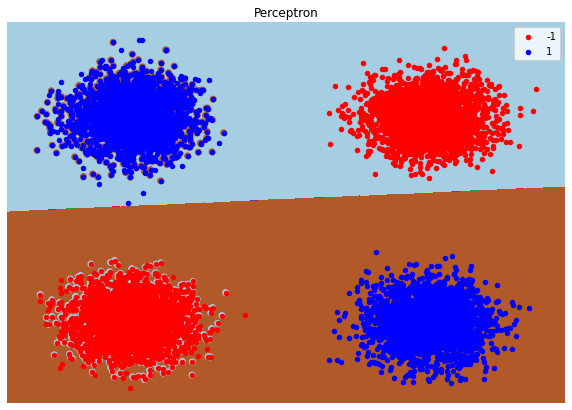

Converge in 100 iteration with learning-rate: 0.0001
Accuracy: 0.495


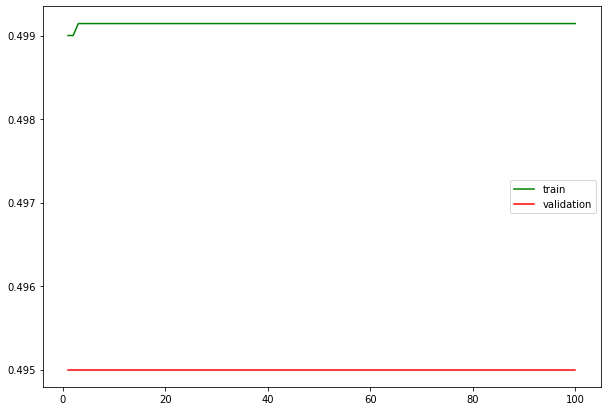

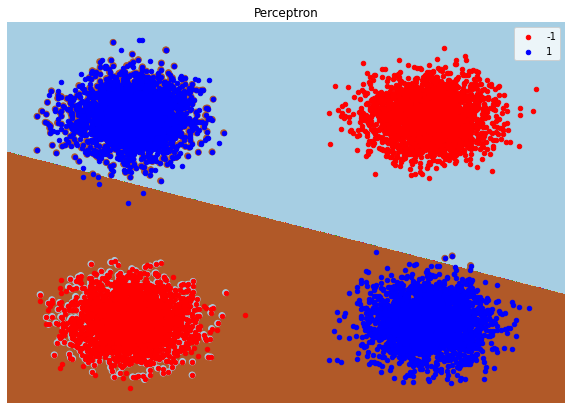

Converge in 100 iteration with learning-rate: 0.001
Accuracy: 0.4945


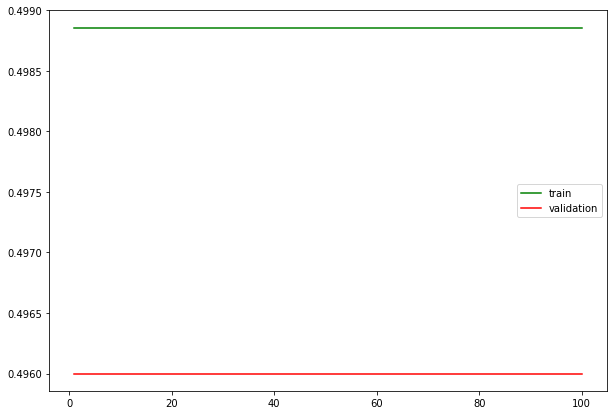

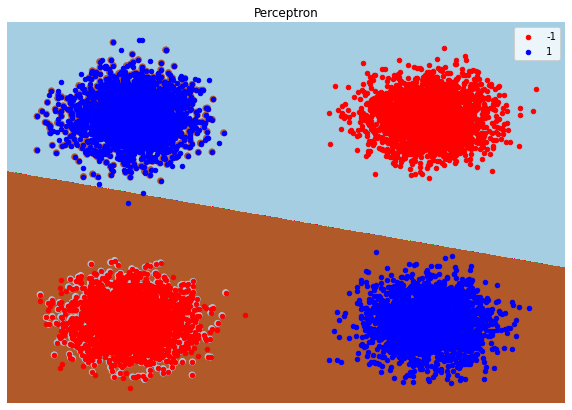

Converge in 100 iteration with learning-rate: 0.01
Accuracy: 0.5035


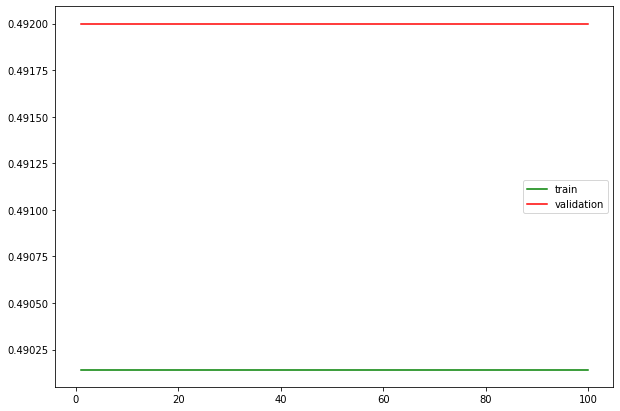

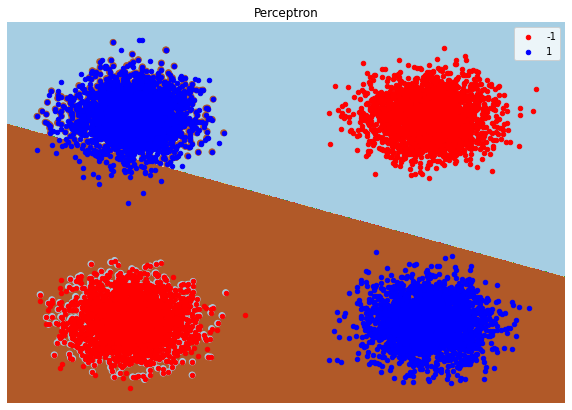

In [19]:
learning_rates = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
for lr in learning_rates:
    adaline = Adaline()
    train_errors, val_errors, iteration = adaline.fit(x_train, x_val, y_train.tolist(), y_val.tolist(), lr=lr)
    acc = adaline.score(x_test, y_test)
    print('Converge in {} iteration with learning-rate: {}'.format(iteration, lr))
    print('Accuracy: {}'.format(acc))
    error_plotter(train_errors, val_errors)
    decision_boundary_plotter(x_train, y_train, adaline)

Converge in 100 iteration with activation function: linear
Accuracy: 0.5035


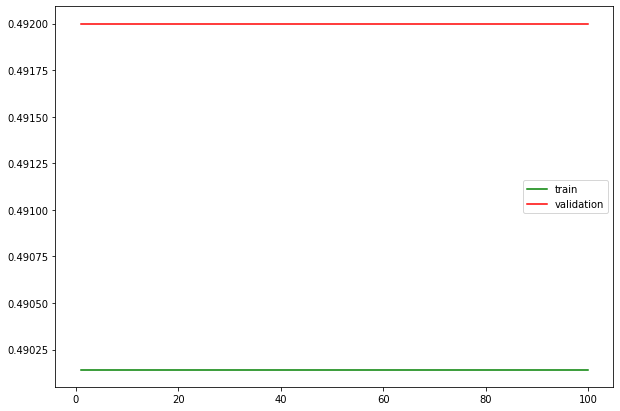

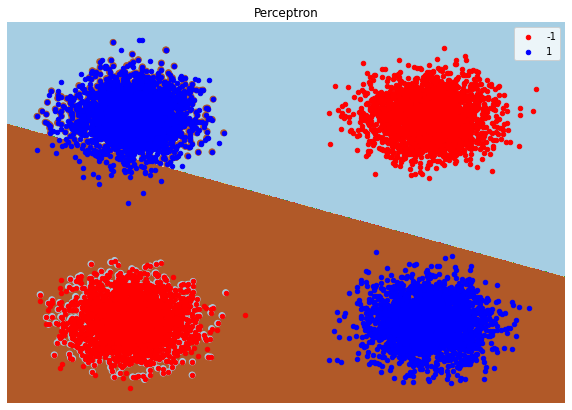

Converge in 100 iteration with activation function: relu
Accuracy: 0.465


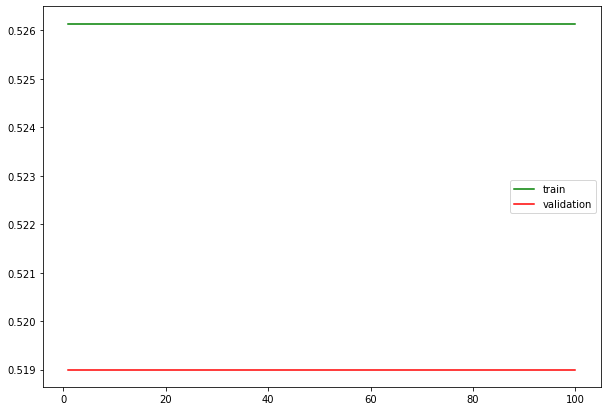

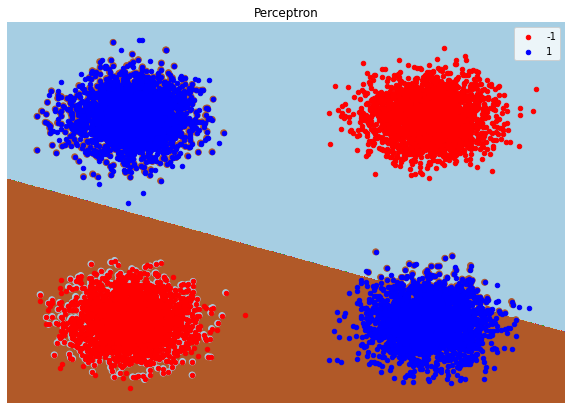

Converge in 100 iteration with activation function: sigmoid
Accuracy: 0.5035


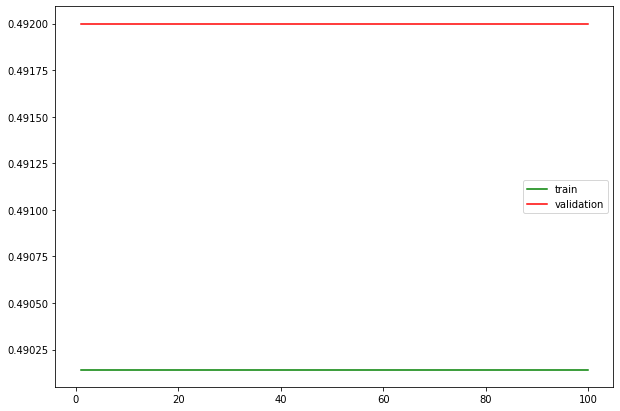

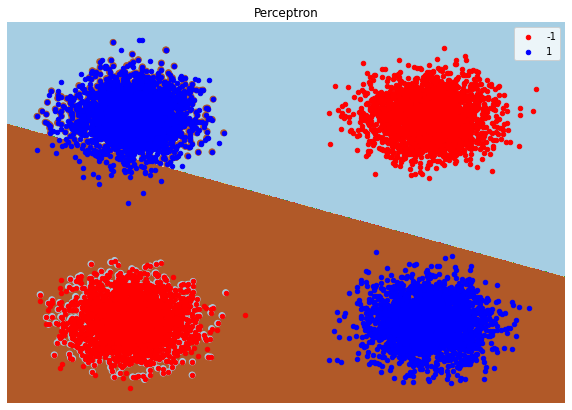

Converge in 100 iteration with activation function: tanh
Accuracy: 0.5035


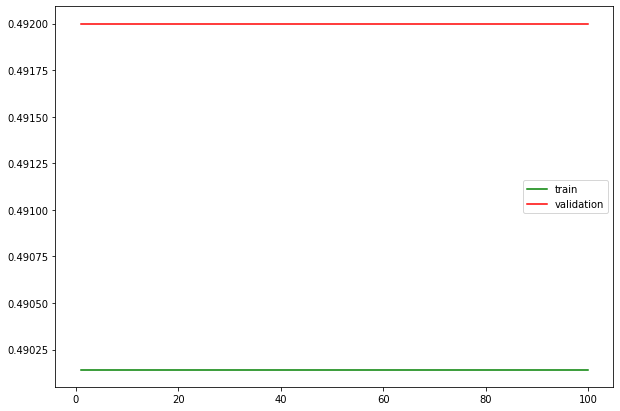

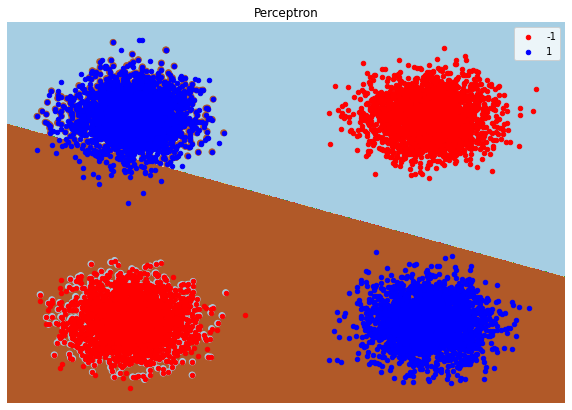

In [20]:
act_funcs = ['linear', 'relu', 'sigmoid', 'tanh']
for func in act_funcs:
    adaline = Adaline()
    train_errors, val_errors, iteration = adaline.fit(x_train, x_val, y_train.tolist(), y_val.tolist(), act_func=func)
    acc = adaline.score(x_test, y_test)
    print('Converge in {} iteration with activation function: {}'.format(iteration, func))
    print('Accuracy: {}'.format(acc))
    error_plotter(train_errors, val_errors)
    decision_boundary_plotter(x_train, y_train, adaline)

Converge in 2 iteration with learning-rate: 0.0001
Accuracy: 0.9995


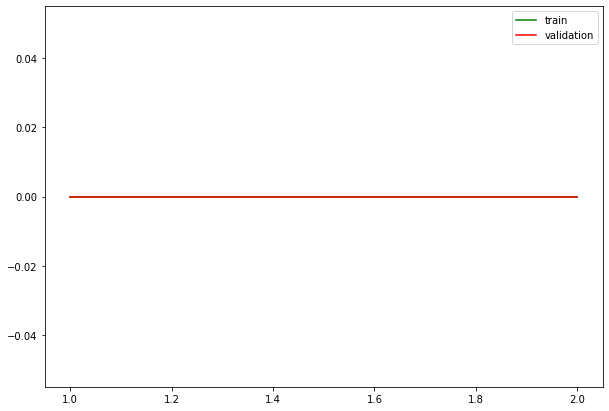

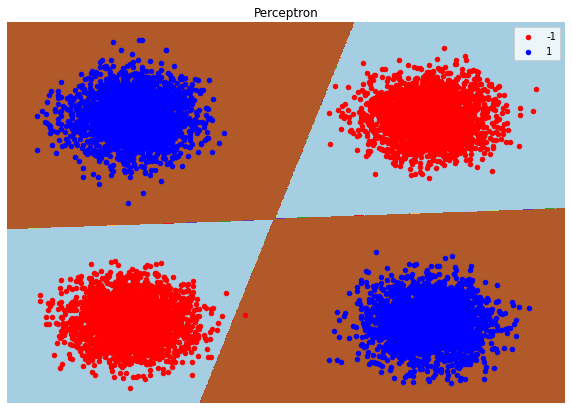

Converge in 2 iteration with learning-rate: 0.001
Accuracy: 0.9995


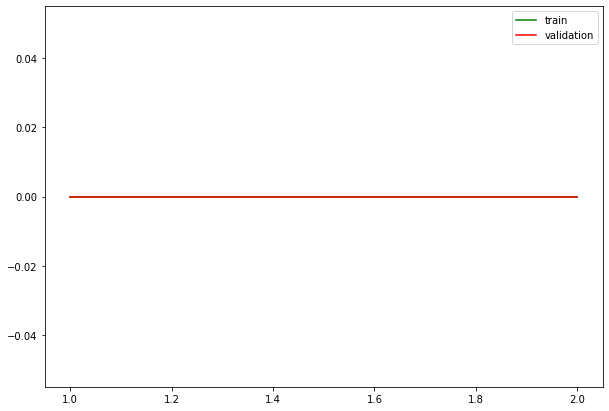

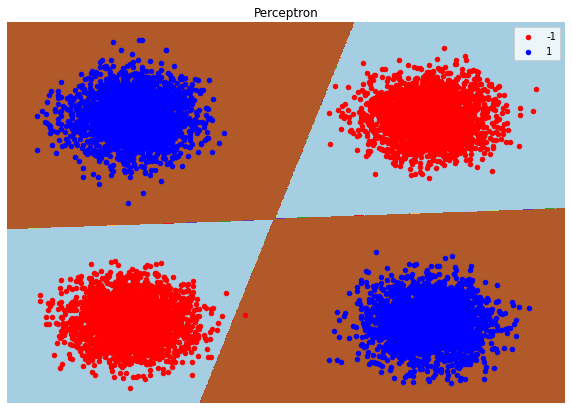

Converge in 2 iteration with learning-rate: 0.01
Accuracy: 0.9995


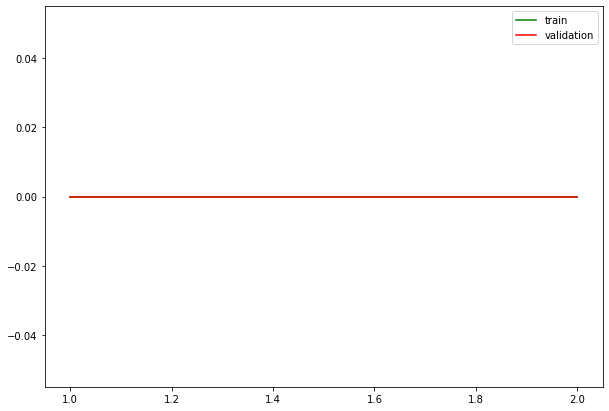

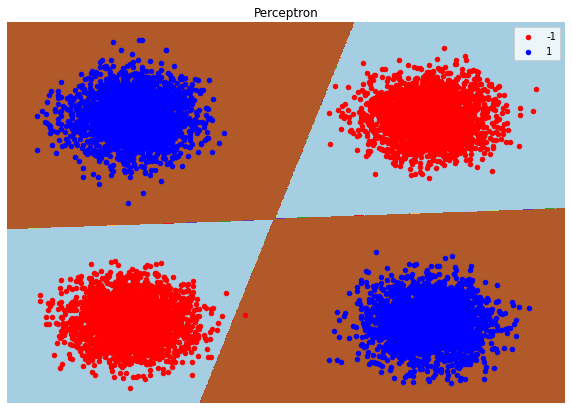

Converge in 2 iteration with learning-rate: 0.1
Accuracy: 0.9995


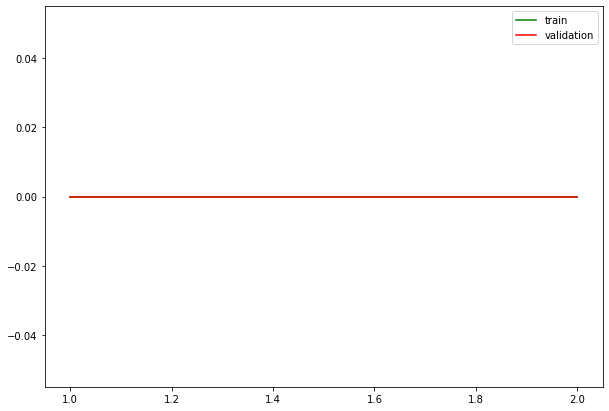

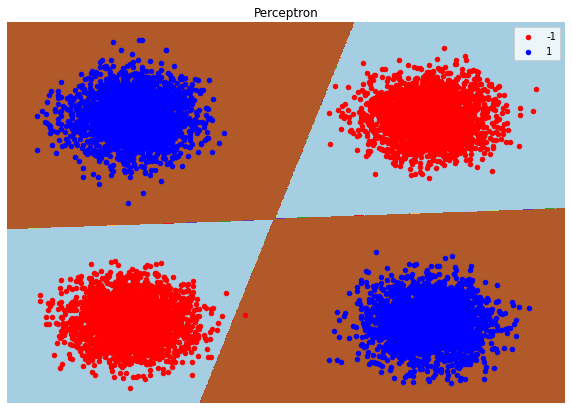

Converge in 2 iteration with learning-rate: 0.9
Accuracy: 0.9995


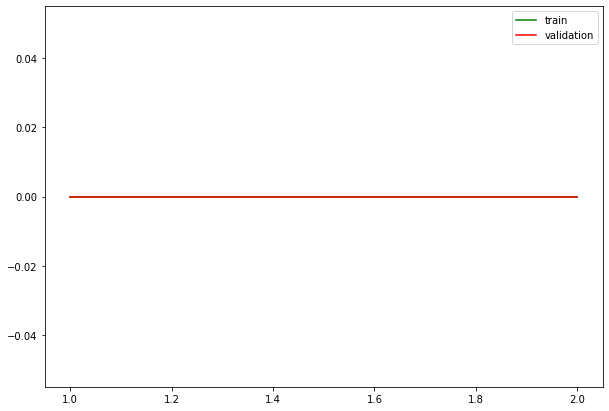

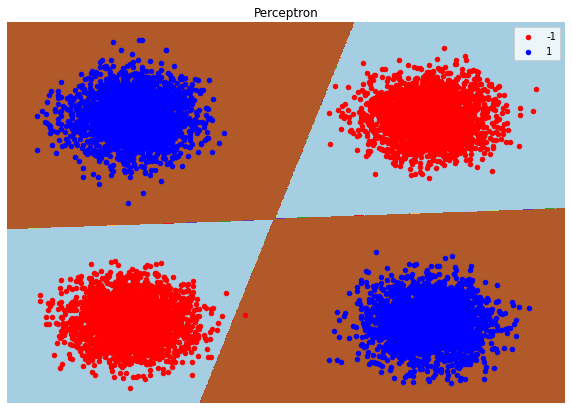

In [21]:
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1, 9e-1]
for lr in learning_rates:
    perceptron = Perceptron()
    train_errors, val_errors, iteration = perceptron.fit(x_train, x_val, y_train.tolist(), y_val.tolist(), lr=lr, not_linear=True)
    acc = perceptron.score(x_test, y_test)
    print('Converge in {} iteration with learning-rate: {}'.format(iteration, lr))
    print('Accuracy: {}'.format(acc))
    error_plotter(train_errors, val_errors)
    decision_boundary_plotter(x_train, y_train, perceptron)

Converge in 2 iteration with activation function: linear
Accuracy: 0.9995


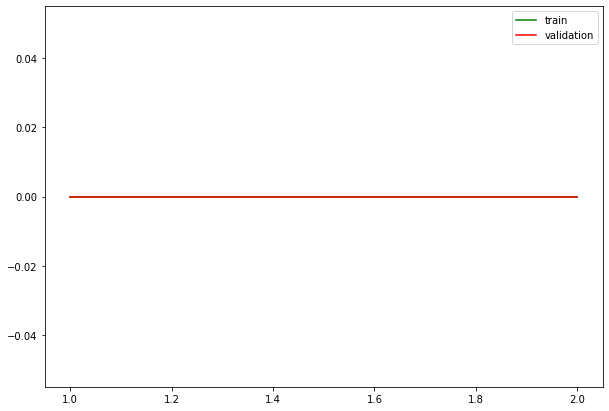

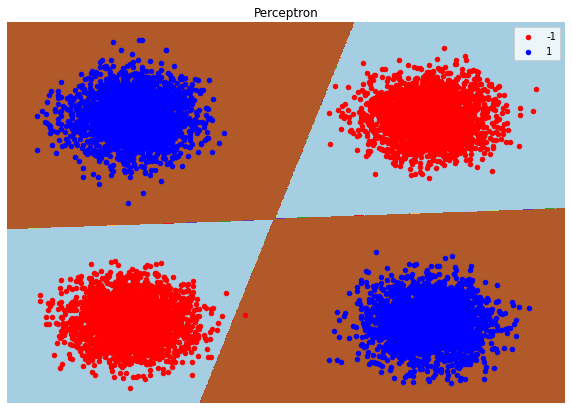

Converge in 2 iteration with activation function: relu
Accuracy: 0.9995


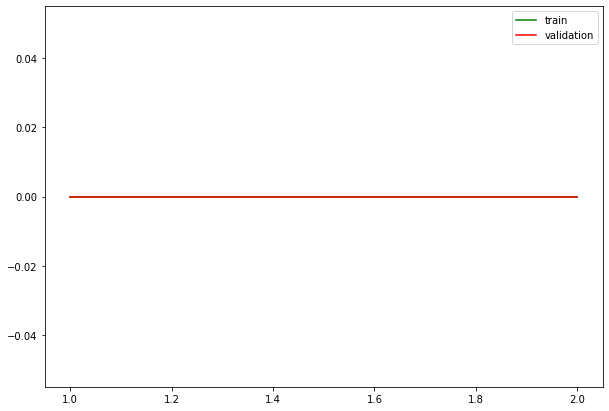

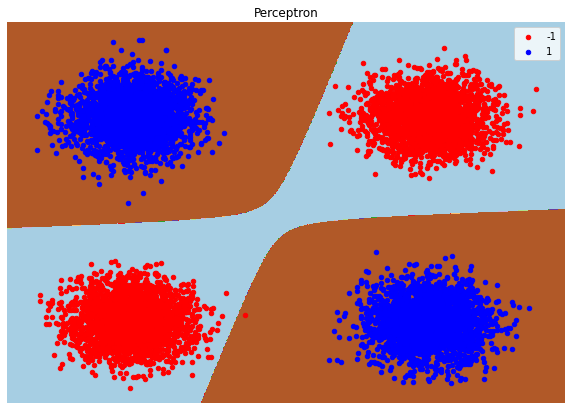

Converge in 2 iteration with activation function: sigmoid
Accuracy: 0.9995


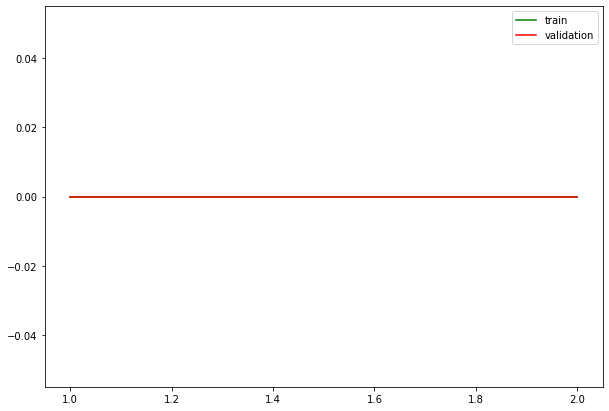

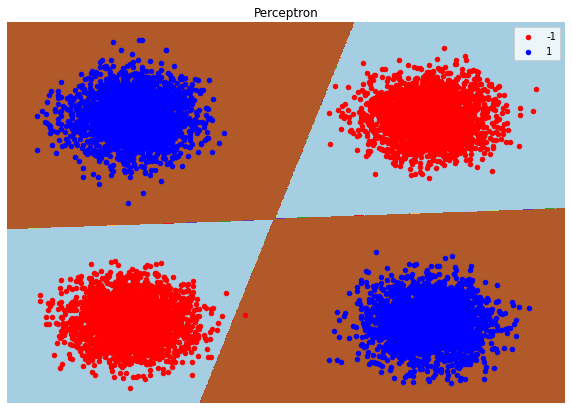

Converge in 2 iteration with activation function: tanh
Accuracy: 0.9995


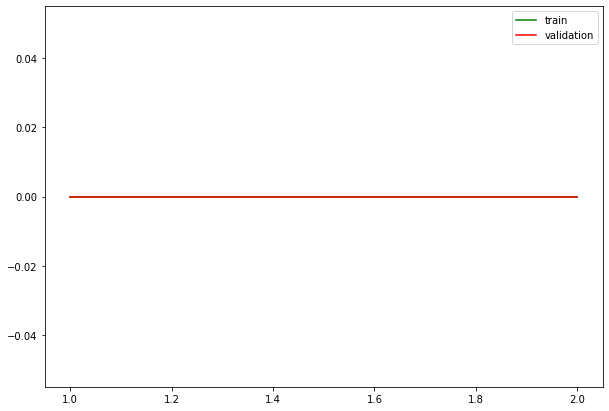

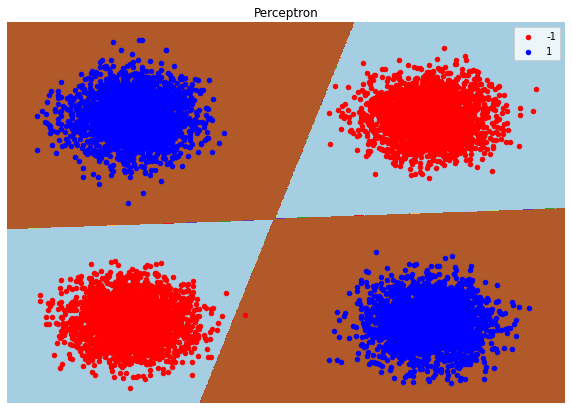

In [22]:
act_funcs = ['linear', 'relu', 'sigmoid', 'tanh']
for func in act_funcs:
    perceptron = Perceptron()
    train_errors, val_errors, iteration = perceptron.fit(x_train, x_val, y_train.tolist(), y_val.tolist(), act_func=func, not_linear=True)
    acc = perceptron.score(x_test, y_test)
    print('Converge in {} iteration with activation function: {}'.format(iteration, func))
    print('Accuracy: {}'.format(acc))
    error_plotter(train_errors, val_errors)
    decision_boundary_plotter(x_train, y_train, perceptron)